# load data

In [184]:
%run ./function.ipynb

In [185]:
PATH = 'D:/Temp/NCTU/crystal/第二階段/new_alert/日數分類_營業日/'
FILE = 'TWN_A11_01_day15_with_aggregated_txn_scenario_txn_type_key_營業日.csv'
df = pd.read_csv(PATH + FILE)
df.columns

Index(['alert_id', 'run_date', 'primary_entity_level_code',
       'primary_entity_number', 'scenario_name', 'TO_SAR', 'Acct_No',
       'Cust_No', 'Cust_Key', 'Cust_Segmentation', 'Cust_Typ_Cd', 'Cust_Id_Id',
       'Cust_Id_Typ_Desc', 'Cust_Id_State_Cd', 'Cust_Dt_Of_Birth',
       'Cust_Sts_Desc', 'Street_Postal_Cd', 'Street_Cntry_Cd',
       'Mailing_Postal_Cd', 'Mailing_Cntry_Cd', 'Residence_Cntry_Cd',
       'Citizenship_Cntry_Cd', 'Org_Cntry_Of_Buz_Cd', 'Empl_No', 'Ocup_Code',
       'job_title_code', 'Lst_Cont_Dt', 'Politically_Exposed_Pers_Ind',
       'Non_Prft_Org_Ind', 'Cust_Since_Dt', 'Lst_Susp_Actv_Rpt_Dt',
       'Extnl_Cust_Ind', 'Negative_News_Ind', 'Prim_Br_No', 'Obu_Ind',
       'Riskclass_Cd', 'risk_score', 'last_risk_assessment_date',
       'change_current_ind', 'change_begin_date', 'change_end_date',
       'Credit_Amt', 'number_of_Credit', 'Debit_Amt', 'number_of_Debit'],
      dtype='object')

In [186]:
df['TO_SAR'] = df['TO_SAR'].replace(np.nan, 0)
df['TO_SAR'] = df['TO_SAR'].replace('F', 1)
df['TO_SAR'] = df['TO_SAR'].replace('NF', 1)

In [188]:
df['TO_SAR'].value_counts()

0    86324
1      446
Name: TO_SAR, dtype: int64

In [189]:
SAR_type = 'TO_SAR'
train_set, test_set = ReadFile(df, SAR_type)

Verify on time series
shape of data: (86770, 39)
total number of TO_SAR: 446
********************************
time interval in train set:2019-03-04~2020-04-29
TO_SAR in train set: 267
TO_SAR/Total in train set 0.005128599143312653
split dataset to train, test...
********************************
time interval in test set:2020-02-19~2020-12-31
TO_SAR in test set: 179
TO_SAR/Total in test set 0.0051571638479933155
********************************
train data shape:  (52061, 38)
test data shape:  (34709, 38)


In [190]:
train_set = train_set.dropna(subset= ['Credit_Amt', 'number_of_Credit', 'Debit_Amt', 'number_of_Debit'])
test_set = test_set.dropna(subset= ['Credit_Amt', 'number_of_Credit', 'Debit_Amt', 'number_of_Debit'])

In [191]:
SAR = train_set[train_set.TO_SAR!= 0]
Non_SAR = train_set[train_set.TO_SAR== 0]

# function

In [192]:
def intialPoint(feature, data):
    return data[feature][np.random.randint(0, len(data))]

In [193]:
def conditionalEntropy(new_sam_0, new_sam_1):
    total = len(new_sam_1) + len(new_sam_0)
    return Entropy(new_sam_0, SAR_type) * (len(new_sam_0) / total) \
            + Entropy(new_sam_1, SAR_type) * (len(new_sam_1) / total)

In [194]:
def recallFilterRate(x_thre, y_thre, x_name, y_name, data):
    idx1 = set(data[data[x_name] > x_thre].index)
    idx2 = set(data[data[y_name] > y_thre].index)
    
    idx = list(idx1 & idx2)
    
    new_sam_1 = data.iloc[idx]
    new_sam_0 = data.drop(index= new_sam_1.index)
    
    if len(set(new_sam_1.index) & set(new_sam_0.index)) != 0:
        raise ValueError('new_sam_1 and new_sam_0 are voerlapped')
        
    TP = new_sam_1[new_sam_1[SAR_type] != 0].shape[0]
    TN = new_sam_0[new_sam_0[SAR_type] == 0].shape[0]
    FP = new_sam_1[new_sam_1[SAR_type] == 0].shape[0]
    FN = new_sam_0[new_sam_0[SAR_type] != 0].shape[0]
    
    recall = TP / (TP + FN)
    filter_rate = (TN + FN) / (TP + TN + FP + FN)
    
    return recall, filter_rate

# Newton Method

## original version
2022/10/12 加入 backtracking line search

In [138]:
def finiteDifferenceIG(x1, y1, x_name, y_name, data):
    x2 = data.loc[data[x_name] > x1, x_name].reset_index(drop= True)[90]
    y2 = data.loc[data[y_name] > y1, y_name].reset_index(drop= True)[0]
    print(f'x1:{x1}, y1:{y1}')
    print(f'x2:{x2}, y2:{y2}')
    delta_x = x2 - x1
    delta_y = y2 - y1
    
    z = informationGain(x1, y1, x_name, y_name, data)
    z_delta_x = informationGain(x1 + delta_x, y1, x_name, y_name, data)
    z_delta_y = informationGain(x1, y1 + delta_y, x_name, y_name, data)
    z_delta_2x = informationGain(x1 + delta_x * 2, y1, x_name, y_name, data)
    z_delta_2y = informationGain(x1, y1 + delta_y * 2, x_name, y_name, data)
    z_delta_xy = informationGain(x1 + delta_x, y1 + delta_y, x_name, y_name, data)
    
    grad = np.array([(z_delta_x - z) / delta_x, (z_delta_y - z) / delta_y])
    hessian = np.array([[(z_delta_2x - z_delta_x * 2 + z) / (delta_x * delta_x), (z_delta_xy - z_delta_x - z_delta_y + z) / (delta_x * delta_y)], \
                       [(z_delta_xy - z_delta_x - z_delta_y + z) / (delta_x * delta_y), (z_delta_2y - z_delta_y * 2 + z) / (delta_y * delta_y)]])
    
    return grad, hessian

In [139]:
def Newton(x1, y1, x_name, y_name, data):
    results = pd.DataFrame(columns= ['iteration number', 'x1', 'y1', 'new x1', 'new y1', 'information gain', 'recall', 'filter rate'])
    n = 1
    while n < N_max:
        grads, hessian = finiteDifferenceIG(x1, y1, x_name, y_name, data)
        print(f'gradient: {grads}')
        print(f'hessian matrix:\n{hessian}')
        
        if np.linalg.det(hessian) == 0:
            raise ValueError('hessian matirx is singular matrix, can not invertible')
        
        temp_point = np.array([[x1], [y1]]) - step_size * np.linalg.inv(hessian) @ grads
    
        information_gain = informationGain(new_points[0], new_points[1], x_name, y_name, data)
    
        recall, filter_rate = recallFilterRate(new_points[0], new_points[1], x_name, y_name, data)
        results = results.append({'iteration number': n, 'x1':x1, 'y1':y1, 'new x1': new_points[0], 'new y1': new_points[1], 'information gain':information_gain, \
                                  'recall':recall, 'filter rate': filter_rate}, ignore_index= True)
    
        if np.linalg.norm(grads, 2) < eplison:
            print('Early stopping' + '------' * 8 + f'\niteration number:{n} new x1:{new_points[0]}, new y1:{new_points[1]}')
            break
            
            
        x1 = new_points[0]
        y1 = new_points[1]
        n += 1
    
    print('Finish' + '-----' * 8 + f'\niteration number:{n} new x1: {new_points[0]}, new y1: {new_points[1]}')
    
    return results

In [140]:
#hyperparameter
SAR_type = 'TO_SAR'
eplison = 1e-10
N_max = 1000
x_name = 'Credit_Amt'
y_name = 'number_of_Credit'
father_entropy = Entropy(train_set, SAR_type)

In [141]:
if __name__ == '__main__':
    np.random.seed(1022)
    x1 = intialPoint('Credit_Amt', train_set)
    y1 = intialPoint('number_of_Credit', train_set)
    #print(f'x1:{x1}, y1:{y1}')
    results = Newton(x1, y1, x_name, y_name, train_set)

x1:0.0, y1:0.0
x2:1011275.0, y2:1.0


TypeError: informationGain() takes 4 positional arguments but 5 were given

In [ ]:
results.tail(10)

,x1,y1,new x1,new y1,information gain,recall,filter rate
989,224704.739396,62.424185,224704.739396,62.758196,0.000006,0.007491,0.011448
990,224704.739396,62.758196,224704.739396,63.087476,0.000004,0.007491,0.010853
991,224704.739396,63.087476,224704.739396,62.391699,0.000006,0.007491,0.011448
992,224704.739396,62.391699,224704.739396,62.726171,0.000006,0.007491,0.011448
993,224704.739396,62.726171,224704.739396,63.055904,0.000004,0.007491,0.010853
994,224704.739396,63.055904,224704.739396,62.359168,0.000006,0.007491,0.011448
995,224704.739396,62.359168,224704.739396,62.694101,0.000006,0.007491,0.011448
996,224704.739396,62.694101,224704.739396,63.024288,0.000004,0.007491,0.010853
997,224704.739396,63.024288,224704.739396,62.326593,0.000006,0.007491,0.011448
998,224704.739396,62.326593,224704.739396,62.661987,0.000006,0.007491,0.011448


## new BFGS
2022/10/19

In [196]:
def informationGain(point, x_name, y_name, data):
    
    idx1 = set(data[data[x_name] >= float(point[0])].index)
    idx2 = set(data[data[y_name] >= float(point[1])].index)
    
    #idx3 = set(data[data[y_name] >= float(y_thre)].index)
    
    idx = list(idx1 & idx2)
    new_sam_1 = data.iloc[idx]
    new_sam_0 = data.drop(index= new_sam_1.index)
    #print(len(new_sam_1), len(new_sam_0))
    if len(set(new_sam_1.index) & set(new_sam_0.index)) != 0:
        raise ValueError('new sam 0 and new sam 1 are overlapped')
        
    return -(father_entropy - conditionalEntropy(new_sam_0, new_sam_1))

In [273]:
data = train_set
if len(np.sort(np.unique(data.loc[data[y_name] > 5, y_name]), kind= 'stable')) > auxiliary_point_select_behind_y:
    print('z')
else:
    print('a')

z


In [197]:
def gradientIG(point, x_name, y_name, data):
    x1 = float(point[0])
    y1 = float(point[1])

    if len(np.sort(np.unique(data.loc[data[x_name] > x1, x_name]), kind= 'stable')) > auxiliary_point_select_behind_x:
        x2 = np.sort(np.unique(data.loc[data[x_name] > x1, x_name]), kind= 'stable')[auxiliary_point_select_behind_x]
    else:
        x2 = np.sort(np.unique(data.loc[data[x_name] < x1, x_name]), kind= 'stable')[-auxiliary_point_select_behind_x]
    
    if len(np.sort(np.unique(data.loc[data[y_name] > y1, y_name]), kind= 'stable')) > auxiliary_point_select_behind_y:
        y2 = np.sort(np.unique(data.loc[data[y_name] > y1, y_name]), kind= 'stable')[auxiliary_point_select_behind_y]
    else:
        y2 = np.sort(np.unique(data.loc[data[y_name] < y1, y_name]), kind= 'stable')[-auxiliary_point_select_behind_y]
    
    delta_x = x2 - x1
    delta_y = y2 - y1
    
    z = informationGain(point, x_name, y_name, data)
    z_delta_x = informationGain(np.array([[x2], [y1]]), x_name, y_name, data)
    z_delta_y = informationGain(np.array([[x1], [y2]]), x_name, y_name, data)
    
    grad = np.array([[(z_delta_x - z) / delta_x], [(z_delta_y - z) / delta_y]])
    return grad

In [198]:
def informationGain(point, x_name, y_name, data):
    
    idx1 = set(data[data[x_name] >= float(point[0])].index)
    idx2 = set(data[data[y_name] >= float(point[1])].index)
    
    #idx3 = set(data[data[y_name] >= float(y_thre)].index)
    idx = list(idx1 & idx2)
    new_sam_1 = data.iloc[idx]
    new_sam_0 = data.drop(index= new_sam_1.index)
    
    if len(set(new_sam_1.index) & set(new_sam_0.index)) != 0:
        raise ValueError('new sam 0 and new sam 1 are overlapped')
        
    return -(father_entropy - conditionalEntropy(new_sam_0, new_sam_1))

In [199]:
def auxiliaryPoint(point, feature, number, data):
    delta = (data[feature].max() - data[feature].min()) / number
    
    return point + delta

In [200]:
def lineSearch(point, update_direction, grads, data):
    a = 1
    c1 = 1e-4
    c2 = 0.9
    z = informationGain(point, x_name, y_name, data)
    new_point = point + a * update_direction
    new_grads = gradientIG(point, x_name, y_name, data)
    new_z = informationGain(new_point, x_name, y_name, data)
    print(f'before loop')
    while (new_z >= z + (c1 * a * grads.T @ update_direction)) or (new_grads.T @ update_direction <= c2 * (grads.T @ update_direction)):
        a *= 0.5
        new_point = point + a * update_direction
        new_grads = gradientIG(new_point, x_name, y_name, data)
        
    return a

In [201]:
def Recall(point, x_name, y_name, data):
    idx1 = set(data[data[x_name] > float(point[0])].index)
    idx2 = set(data[data[y_name] > float(point[1])].index)
    idx = list(idx1 & idx2)
    #print(f'idx:{len(idx)}')
    new_sam_1 = data.iloc[idx]
    new_sam_0 = data.drop(index= new_sam_1.index)
    
    if len(set(new_sam_1.index) & set(new_sam_0.index)) != 0:
        raise ValueError('new sam 1 and new sam 0 are overlapped')
    
    TP = new_sam_1[new_sam_1[SAR_type] != 0].shape[0]
    TN = new_sam_0[new_sam_0[SAR_type] == 0].shape[0]
    FP = new_sam_1[new_sam_1[SAR_type] == 0].shape[0]
    FN = new_sam_0[new_sam_0[SAR_type] != 0].shape[0]
    
    return -(TP / (TP + FN))

In [202]:
def RecallFilterRate(point, x_name, y_name, data):
    idx1 = set(data[data[x_name] > float(point[0])].index)
    idx2 = set(data[data[y_name] > float(point[1])].index)
    
    idx = list(idx1 & idx2)
    
    new_sam_1 = data.iloc[idx]
    new_sam_0 = data.drop(index= new_sam_1.index)
    
    if len(set(new_sam_1.index) & set(new_sam_0.index)) != 0:
        raise ValueError('new_sam_1 and new_sam_0 are voerlapped')
        
    TP = new_sam_1[new_sam_1[SAR_type] != 0].shape[0]
    TN = new_sam_0[new_sam_0[SAR_type] == 0].shape[0]
    FP = new_sam_1[new_sam_1[SAR_type] == 0].shape[0]
    FN = new_sam_0[new_sam_0[SAR_type] != 0].shape[0]
    
    recall = TP / (TP + FN)
    filter_rate = (TN + FN) / (TP + TN + FP + FN)
    
    return recall, filter_rate

In [203]:
def BFGS(point0, x_name, y_name, data):
    results = pd.DataFrame(columns= ['iteration number', 'x1', 'y1', 'new x1', 'new y1', 'information gain', 'recall', 'filter rate'])
    d = 2
    grads = gradientIG(point0, x_name, y_name, data)
    H = np.eye(d)
    point = point0
    n = 1
    
    while np.linalg.norm(grads) > 1e-50:
        if n > N_max:
            print(f'Maximum iteration reached!')
            break
        
        
        update_direction = -H @ grads
        #step_size = lineSearch(point, update_direction, grads, data)
        print(f'update_direction:\n{update_direction}')
        new_point = point + (step_size * update_direction)
        new_grads = gradientIG(new_point, x_name, y_name, data)
        
        if np.isnan(new_grads).all() == True:
            break
    
        y = new_grads - grads
        s = new_point - point
        denominator = 1 / (y.T @ s)
        li = np.eye(d) - (denominator * (s @ y.T))
        ri = np.eye(d) - (denominator * (y @ s.T))
        H = li @ H @ ri + (denominator * (s @ s.T))
        grads = new_grads
        point = new_point
        
        information_gain = informationGain(point, x_name, y_name, data)
        recall, filter_rate = RecallFilterRate(point, x_name, y_name, data)
        
        print(f'n={n}, new x1:{point[0][0]}, new y1: {point[1][0]},\ninformation gain: {information_gain}, recall: {recall}, filter rate: {filter_rate}')
        
        results = results.append({'iteration number': n, 'x1': float(point[0]), 'y1': float(point[1]), 'new x1': float(new_point[0]), \
                                 'new y1': float(new_point[1]), 'information gain': information_gain, 'recall': recall, \
                                 'filter rate': filter_rate}, ignore_index= True)
        print('*'*32)
        print(f'new_grads:\n{new_grads}')
        print(f'hessian matrix:\n{H}')
        n += 1

    if np.linalg.norm(grads) < 1e-50:
        print('Early stopping!')
    
    return results

In [ ]:
#hyperparameter
SAR_type = 'TO_SAR'
eps = 1e-1000
N_max = 1000
x_name = 'Credit_Amt'
y_name = 'number_of_Credit'
#step_size = np.array([[1e12], [1e6]])
step_size = 1
auxiliary_point_select_behind_x = 3
auxiliary_point_select_behind_y = 3
father_entropy = Entropy(train_set, SAR_type)

In [ ]:
if __name__ == '__main__':
    np.random.seed(928)
    x1 = intialPoint('Credit_Amt', train_set)
    y1 = intialPoint('number_of_Credit', train_set)
    print(f'initial  point x1:{x1}, y1:{y1}')
    point = np.array([[x1], [y1]])
    results = BFGS(point, x_name, y_name, train_set)

initial  point x1:537664.0, y1:20.0
update_direction:
[[-2.83161263e-11]
 [-3.93734085e-06]]
n=1, new x1:537664.0, new y1: 19.999996062659154,
information gain: -0.00020901150114722294, recall: 0.052434456928838954, filter rate: 0.8777564348828275
********************************
new_grads:
[[2.83161263e-11]
 [2.43177212e-08]]
hessian matrix:
[[1.         0.        ]
 [0.         1.00621456]]
update_direction:
[[-2.83161263e-11]
 [-2.44688452e-08]]
n=2, new x1:537664.0, new y1: 19.999996038190307,
information gain: -0.00020901150114722294, recall: 0.052434456928838954, filter rate: 0.8777564348828275
********************************
new_grads:
[[2.83161263e-11]
 [2.43177210e-08]]
hessian matrix:
[[1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.23366984e+08]]
update_direction:
[[-2.83161263e-11]
 [-3.00000390e+00]]
n=3, new x1:537664.0, new y1: 16.99999213705215,
information gain: -0.00013575523848892435, recall: 0.0898876404494382, filter rate: 0.8456396465616596
*******************

In [ ]:
results.tail()

,iteration number,x1,y1,new x1,new y1,information gain,recall,filter rate
995,996.0,537664.0,15.985015,537664.0,15.985015,-0.000122,0.104869,0.831310
996,997.0,537664.0,19.502456,537664.0,19.502456,-0.000209,0.052434,0.877756
997,998.0,537664.0,19.514469,537664.0,19.514469,-0.000209,0.052434,0.877756
998,999.0,537664.0,16.016926,537664.0,16.016926,-0.000136,0.089888,0.845640
999,1000.0,537664.0,19.510494,537664.0,19.510494,-0.000209,0.052434,0.877756


## 加入邊界條件
使用懲罰函數中的內點法，限制 x, y 必須為正，此時目標函數如下
$$min IG(x, y)$$
$$s.t. x\geq0\quad and\quad y\geq0$$
內點法的概念是初始點在可行區域內，建立起一道高牆，當接近邊界時懲罰會大增，使後續更新無法離開可行解的區域內，常見的內點法的逞罰函數會取倒數或log
$$min IG(x,y) + \gamma(ln(x) + ln(y))$$
另外x, y 上限受到training 資料影響，因為當越接近上限時，我們知道此時的資料幾乎會都分到 TO_SAM =0 的那類，filter rate 最大，但 recall 最低
2022/10/19

In [225]:
# def gradientPenalty(point):
#     if np.any(point < 0): # any 是只要有一個是 True 就 output True，但 all 是要全部都為 True 才 output True
#         raise ValueError('point are negative!')
#     return 1 / point

In [226]:
def gradientPenalty(point, upperbound=np.zeros((2,1))):
    if np.any(point < 0): # any 是只要有一個是 True 就 output True，但 all 是要全部都為 True 才 output True
        raise ValueError('point are negative!')

    if np.linalg.norm(upperbound) == 0:
        return 1 / point
    else:
        return 1 / (upperbound - point)

In [227]:
def BFGSWithPenalty(point0, x_name, y_name, data):
    results = pd.DataFrame(columns= ['iteration number', 'x1', 'y1', 'new x1', 'new y1', 'information gain', 'recall', 'filter rate'])
    d = 2
    gradIG = gradientIG(point0, x_name, y_name, data)
    gradPenalty = gradientPenalty(point0)  
    grads = gradIG + (gradPenalty * gamma)
    H = np.eye(d)
    print(f'Hessian matrix:\n{H}')
    point = point0
    n = 1
    
    while np.linalg.norm(grads) > 1e-50:
        if n > N_max:
            print(f'Maximum iteration reached!')
            break

        update_direction = -H @ grads
        #step_size = lineSearch(point, update_direction, grads, data)
        print(f'update_direction:\n{update_direction}')
        new_point = point + step_size * update_direction

        # if np.any(new_point < 0):
        #     print('touch the boundary!')
        #     new_point[new_point < 0] = 0
            
        information_gain = informationGain(new_point, x_name, y_name, data)
        recall, filter_rate = RecallFilterRate(new_point, x_name, y_name, data)
        print(f'n={n}, new x1:{float(new_point[0])}, new y1: {float(new_point[1])},\ninformation gain: {information_gain}, recall: {recall}, filter rate: {filter_rate}')
        
        results = results.append({'iteration number': n, 'x1': float(point[0]), 'y1': float(point[1]), 'new x1': float(new_point[0]), \
                                 'new y1': float(new_point[1]), 'information gain': information_gain, 'recall': recall, \
                                 'filter rate': filter_rate}, ignore_index= True)        
        
        new_gradIG = gradientIG(new_point, x_name, y_name, data)
        new_gardPenalty = gradientPenalty(new_point)
        new_grads = new_gradIG + (new_gardPenalty * gamma)

        # if np.isnan(new_grads).all() == True:
        #     break
        #print(f'new_grads:{new_grads}')

        y = new_grads - grads
        s = new_point - point
        denominator = 1 / (y.T @ s)
        li = np.eye(d) - (denominator * (s @ y.T))
        ri = np.eye(d) - (denominator * (y @ s.T))
        H = li @ H @ ri + (denominator * (s @ s.T))
        grads = new_grads
        point = new_point

        print(f'*'*32)
        print(f'new_grads:\n{new_grads}')
        print(f'Hessian matrix:\n{H}')  
        n += 1

    if np.linalg.norm(grads) < 1e-50:
        print('Early stopping!')
    
    return results

In [228]:
#hyperparameter
SAR_type = 'TO_SAR'
eps = 1e-1000
N_max = 1000
x_name = 'Credit_Amt'
y_name = 'number_of_Credit'
#step_size = np.array([[1e12], [1e6]])
step_size = 1
gamma = 1e-10
auxiliary_point_select_behind_x = 3
auxiliary_point_select_behind_y = 3
father_entropy = Entropy(train_set, SAR_type)

In [229]:
if __name__ == '__main__':
    np.random.seed(928)
    x1 = intialPoint('Credit_Amt', train_set)
    y1 = intialPoint('number_of_Credit', train_set)
    print(f'initial  point x1:{x1}, y1:{y1}')
    point = np.array([[x1], [y1]])
    results = BFGSWithPenalty(point, x_name, y_name, train_set)

initial  point x1:537664.0, y1:20.0
Hessian matrix:
[[1. 0.]
 [0. 1.]]
update_direction:
[[-2.83163122e-11]
 [-3.93734585e-06]]
n=1, new x1:537664.0, new y1: 19.999996062654155,
information gain: -0.00020901150114722294, recall: 0.052434456928838954, filter rate: 0.8777564348828275
********************************
new_grads:
[[2.83163122e-11]
 [2.43227212e-08]]
Hessian matrix:
[[1.         0.        ]
 [0.         1.00621584]]
update_direction:
[[-2.83163122e-11]
 [-2.44739073e-08]]
n=2, new x1:537664.0, new y1: 19.99999603818025,
information gain: -0.00020901150114722294, recall: 0.052434456928838954, filter rate: 0.8777564348828275
********************************
new_grads:
[[2.83163122e-11]
 [2.43227210e-08]]
Hessian matrix:
[[1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.23370789e+08]]
update_direction:
[[-2.83163122e-11]
 [-3.00071327e+00]]
n=3, new x1:537664.0, new y1: 16.999282765412218,
information gain: -0.00013575523848892435, recall: 0.0898876404494382, filter rate: 0.8

In [230]:
results.tail()

,iteration number,x1,y1,new x1,new y1,information gain,recall,filter rate
995,996.0,537664.0,19.521871,537664.0,16.030774,-0.000136,0.089888,0.845640
996,997.0,537664.0,16.030774,537664.0,19.517907,-0.000209,0.052434,0.877756
997,998.0,537664.0,19.517907,537664.0,19.513952,-0.000209,0.052434,0.877756
998,999.0,537664.0,19.513952,537664.0,16.030854,-0.000136,0.089888,0.845640
999,1000.0,537664.0,16.030854,537664.0,19.510006,-0.000209,0.052434,0.877756


因為逞罰函數是 ln function，值域界在 $[0, \infty]$，所以上面結果x1, y1 ，不應該出現負的但還可以繼續執行，那是因為我是直接用 ln 的微分，所以避免掉值域區域的問題，所以我在計算微分之前多一個判斷檢查

# 考慮recall
老師提議的方式是利用 sigmoid 代替 indicator function
$$min L(x, y)=-IG(x, y) \times \sigma(recall(x,y))$$
將 sigmoid 平移到$\sigma(0.8)\approx 1$ <br>
透過 product rule and chain rule，我們可以得到新的目標函數的一階微分為
$$\nabla L(x, y)= \nabla -IG(x, y)\times \sigma(recall(x, y)) + -IG(x, y)\times \sigma^{\prime}(recall(x, y)) \times \nabla recall(x,y)$$

In [ ]:
def gradientRecall(point, x_name, y_name, data):
    x1 = float(point[0])
    y1 = float(point[1])

    if len(np.sort(np.unique(data.loc[data[x_name] > x1, x_name]), kind= 'stable')) > auxiliary_point_select_behind_x:
        x2 = np.sort(np.unique(data.loc[data[x_name] > x1, x_name]), kind= 'stable')[auxiliary_point_select_behind_x]
    else:
        x2 = np.sort(np.unique(data.loc[data[x_name] < x1, x_name]), kind= 'stable')[-auxiliary_point_select_behind_x]
    
    if len(np.sort(np.unique(data.loc[data[y_name] > y1, y_name]), kind= 'stable')) > auxiliary_point_select_behind_y:
        y2 = np.sort(np.unique(data.loc[data[y_name] > y1, y_name]), kind= 'stable')[auxiliary_point_select_behind_y]
    else:
        y2 = np.sort(np.unique(data.loc[data[y_name] < y1, y_name]), kind= 'stable')[-auxiliary_point_select_behind_y]
    
    delta_x = x2 - x1
    delta_y = y2 - y1

    z = Recall(point, x_name, y_name, data)
    z_delta_x = Recall(np.array([[x2], [y1]]), x_name, y_name, data)
    z_delta_y = Recall(np.array([[x1], [y2]]), x_name, y_name, data)

    grad = np.array([[(z_delta_x - z) / delta_x], [(z_delta_y - z) / delta_y]])

    return grad

In [ ]:
def sigmoid(x):
    return 1.0 / (1 + np.exp(-(sigmoid_b + sigmoid_w * x)))

In [ ]:
def sigmoidDiff(x):
    tmp = sigmoid(x)
    return tmp * (1 - tmp)

In [231]:
def BFGSWithRecall(point0, x_name, y_name, data):
    results = pd.DataFrame(columns= ['iteration number', 'x1', 'y1', 'new x1', 'new y1', 'information gain', 'recall', 'filter rate'])
    d = 2
    gradIG = gradientIG(point0, x_name, y_name, data)
    gradRecall  = gradientRecall(point0, x_name, y_name, data)
    recall = Recall(point0, x_name, y_name, data)
    information_gain = informationGain(point0, x_name, y_name, data)
    grads = gradIG * sigmoid(recall) + information_gain * sigmoidDiff(recall) * gradRecall
    print(f'recall:{recall}, sigmoid:{sigmoid(recall)}')
    H = np.eye(d)
    point = point0
    n = 1
    
    while np.linalg.norm(grads) > 1e-50:
        if n > N_max:
            print(f'Maximum iteration reached!')
            break
        
        update_direction = -H @ grads
        #step_size = lineSearch(point, update_direction, grads, data)
        print(f'update_direction:\n{update_direction}')
        new_point = point + step_size * update_direction

        information_gain = informationGain(new_point, x_name, y_name, data)
        recall, filter_rate = RecallFilterRate(new_point, x_name, y_name, data)
        
        print(f'n={n}, new x1:{float(point[0])}, new y1: {float(point[1])},\ninformation gain: {information_gain}, recall: {recall}, filter rate: {filter_rate}')
        
        results = results.append({'iteration number': n, 'x1': float(point[0]), 'y1': float(point[1]), 'new x1': float(new_point[0]), \
                                 'new y1': float(new_point[1]), 'information gain': information_gain, 'recall': recall, \
                                 'filter rate': filter_rate}, ignore_index= True)        
        
        new_gradIG = gradientIG(new_point, x_name, y_name, data)
        new_gradRecall = gradientRecall(new_point, x_name, y_name, data)
        new_grads = new_gradIG * sigmoid(recall) + information_gain * sigmoidDiff(recall) * new_gradRecall
        
        y = new_grads - grads
        s = new_point - point
        denominator = 1 / (y.T @ s)
        li = np.eye(d) - (denominator * (s @ y.T))
        ri = np.eye(d) - (denominator * (y @ s.T))
        H = li @ H @ ri + (denominator * (s @ s.T))
        grads = new_grads
        point = new_point
        print(f'*'*32)
        print(f'new_gradIG:\n{new_gradIG}')
        print(f'new_gradRecall:\n{new_gradRecall}')
        #print(f'new_grads:\n{new_grads}')
        print(f'Hessian matrix:\n{H}')
        print(f'recall:{recall}, sigmoid:{sigmoid(recall)}')
        n += 1

    if np.linalg.norm(grads) < 1e-50:
        print('Early stopping!')
    
    return results

In [232]:
#hyperparameter
SAR_type = 'TO_SAR'
eps = 1e-1000
N_max = 1000
x_name = 'Credit_Amt'
y_name = 'number_of_Credit'
#step_size = np.array([[1e12], [1e6]])
step_size = 1
gamma = 1e-10
auxiliary_point_select_behind_x = 3
auxiliary_point_select_behind_y = 3
sigmoid_b = 0.8
sigmoid_w = 5
father_entropy = Entropy(train_set, SAR_type)

In [233]:
if __name__ == '__main__':
    np.random.seed(928)
    x1 = intialPoint('Credit_Amt', train_set)
    y1 = intialPoint('number_of_Credit', train_set)
    print(f'initial  point x1:{x1}, y1:{y1}')
    point = np.array([[x1], [y1]])
    results = BFGSWithRecall(point, x_name, y_name, train_set)

initial  point x1:537664.0, y1:20.0
recall:-0.0449438202247191, sigmoid:0.6399808198918205
update_direction:
[[-1.81217777e-11]
 [-2.33945793e-06]]
n=1, new x1:537664.0, new y1: 20.0,
information gain: -0.00020901150114722294, recall: 0.052434456928838954, filter rate: 0.8777564348828275
********************************
new_gradIG:
[[2.83161263e-11]
 [2.43177342e-08]]
new_gradRecall:
[[0.        ]
 [0.00749063]]
Hessian matrix:
[[1.00000000e+00 1.11442538e-06]
 [1.11442538e-06 8.92832478e-01]]
recall:0.052434456928838954, sigmoid:0.7431054528209959
update_direction:
[[-2.07289290e-11]
 [ 2.50713909e-07]]
n=2, new x1:537664.0, new y1: 19.999997660542068,
information gain: -0.00020901150114722294, recall: 0.052434456928838954, filter rate: 0.8777564348828275
********************************
new_gradIG:
[[2.83161263e-11]
 [2.43177362e-08]]
new_gradRecall:
[[0.        ]
 [0.00749063]]
Hessian matrix:
[[ 1.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.0683489e+07]]
recall:0.05243445692883

In [234]:
results.tail()

,iteration number,x1,y1,new x1,new y1,information gain,recall,filter rate
995,996.0,537664.0,15.788303,537664.0,15.464085,-0.000122,0.104869,0.831310
996,997.0,537664.0,15.464085,537664.0,12.252388,-0.000006,0.213483,0.770361
997,998.0,537664.0,12.252388,537664.0,15.063148,-0.000122,0.104869,0.831310
998,999.0,537664.0,15.063148,537664.0,14.743939,-0.000107,0.127341,0.809278
999,1000.0,537664.0,14.743939,537664.0,14.946898,-0.000107,0.127341,0.809278


## 同時考慮 recall 和下界條件
2022/11/02 <br>
另外就是會遇到接近上限時會找不到輔助點計算斜率，現在是找大於閥值後的第$n$個數，就會變成找小於閥值的第$n$個數

In [240]:
def BFGSWithPenaltyRecall(point0, x_name, y_name, data):
    results = pd.DataFrame(columns= ['iteration number', 'x1', 'y1', 'new x1', 'new y1', 'information gain', 'recall', 'filter rate'])
    d = 2
    gradIG = gradientIG(point0, x_name, y_name, data)
    gradRecall = gradientRecall(point0, x_name, y_name, data)
    gradPenalty = gradientPenalty(point0)
    recall = Recall(point0, x_name, y_name, data)
    information_gain = informationGain(point0, x_name, y_name, data)
    grads = gradIG * sigmoid(recall) + information_gain * sigmoidDiff(recall) * gradRecall + (gamma * gradPenalty)
    print(f'recall:{recall}, sigmoid:{sigmoid(recall)}')
    H = np.eye(d)
    point = point0
    n = 1

    while np.linalg.norm(grads) > 1e-50:
        if n > N_max:
            print(f'maximum iteration reached!')
            break
        
        update_direction = -H @ grads
        print(f'update_direction:\n{update_direction}')
        new_point = point + step_size * update_direction

        information_gain = informationGain(new_point, x_name, y_name, data)
        recall, filter_rate = RecallFilterRate(new_point, x_name, y_name, data)
        
        print(f'n={n}, new x1:{float(point[0])}, new y1: {float(point[1])},\ninformation gain: {information_gain}, recall:{recall}, filter rate:{filter_rate}')

        results = results.append({'iteration number': n, 'x1': float(point[0]), 'y1': float(point[1]), 'new x1': float(new_point[0]), \
                                 'new y1': float(new_point[1]), 'information gain': information_gain, 'recall': recall, \
                                 'filter rate': filter_rate}, ignore_index= True)

        new_gradIG = gradientIG(new_point, x_name, y_name, data)
        new_gradRecall = gradientRecall(new_point, x_name, y_name, data)
        new_gradPenalty = gradientPenalty(new_point)

        new_grads = new_gradIG * sigmoid(recall) + information_gain * sigmoidDiff(recall) * new_gradRecall + (gamma * new_gradPenalty)

        y = new_grads - grads
        s = new_point - point
        denominator = 1 / (y.T @ s)
        li = np.eye(d) - (denominator * (s @ y.T))
        ri = np.eye(d) - (denominator * (y @ s.T))
        H = li @ H @ ri + (denominator * (s @ s.T))
        grads = new_grads
        point = new_point
        print(f'*'*32)
        print(f'new_gradIG:\n{new_gradIG}')
        print(f'new_gradRecall:\n{new_gradRecall}')
        print(f'new_gradPenalty\n:{new_gradPenalty}')
        print(f'Hessian matrix:\n{H}')
        print(f'recall:{recall}, sigmoid:{sigmoid(recall)}')
        n += 1
    
    if np.linalg.norm(grads) < 1e-50:
        print('Early stopping!')

    return results
        

In [241]:
#hyperparameter
SAR_type = 'TO_SAR'
eps = 1e-1000
N_max = 1000
x_name = 'Credit_Amt'
y_name = 'number_of_Credit'
#step_size = np.array([[1e12], [1e6]])
step_size = 1
gamma = 1e-10
auxiliary_point_select_behind_x = 3
auxiliary_point_select_behind_y = 3
sigmoid_b = 0.8
sigmoid_w = 5
father_entropy = Entropy(train_set, SAR_type)

In [242]:
if __name__ == '__main__':
    np.random.seed(928)
    x1 = intialPoint('Credit_Amt', train_set)
    y1 = intialPoint('number_of_Credit', train_set)
    print(f'initial  point x1:{x1}, y1:{y1}')
    point = np.array([[x1], [y1]])
    results = BFGSWithPenaltyRecall(point, x_name, y_name, train_set)

initial  point x1:537664.0, y1:20.0
recall:-0.0449438202247191, sigmoid:0.6399808198918205
update_direction:
[[-1.81219637e-11]
 [-2.33946293e-06]]
n=1, new x1:537664.0, new y1: 20.0,
information gain: -0.00020901150114722294, recall:0.052434456928838954, filter rate:0.8777564348828275
********************************
new_gradIG:
[[2.83161263e-11]
 [2.43177342e-08]]
new_gradRecall:
[[0.        ]
 [0.00749063]]
new_gradPenalty
:[[1.85989763e-06]
 [5.00000058e-02]]
Hessian matrix:
[[1.00000000e+00 1.11442538e-06]
 [1.11442538e-06 8.92834386e-01]]
recall:0.052434456928838954, sigmoid:0.7431054528209959
update_direction:
[[-2.07291206e-11]
 [ 2.50709981e-07]]
n=2, new x1:537664.0, new y1: 19.99999766053707,
information gain: -0.00020901150114722294, recall:0.052434456928838954, filter rate:0.8777564348828275
********************************
new_gradIG:
[[2.83161263e-11]
 [2.43177362e-08]]
new_gradRecall:
[[0.        ]
 [0.00749063]]
new_gradPenalty
:[[1.85989763e-06]
 [5.00000052e-02]]
Hes

In [243]:
results.tail()

,iteration number,x1,y1,new x1,new y1,information gain,recall,filter rate
995,996.0,537664.0,15.187904,537664.0,18.870986,-0.000103,0.078652,0.868767
996,997.0,537664.0,18.870986,537664.0,15.656382,-0.000122,0.104869,0.831310
997,998.0,537664.0,15.656382,537664.0,16.114397,-0.000136,0.089888,0.845640
998,999.0,537664.0,16.114397,537664.0,15.754114,-0.000122,0.104869,0.831310
999,1000.0,537664.0,15.754114,537664.0,15.832801,-0.000122,0.104869,0.831310


## 同時考慮 recall 和上下界條件
2022/11/3 <br>
在上述條件下，目標函數如下
$$
\mathop{min}\limits_{x, y} \mathcal{L}(x, y)=-IG(x,y)\times \sigma(Recall(x,y))+\gamma[ln(x)+ln(y)+ln(M_{x}-x)+ln(M_{y}-y)]
$$
$M_{x}\quad and\quad M_{y}$ 是 x 和 y 在資料集中最大值

In [274]:
def BFGSWithUpDownPenaltyRecall(point0, x_name, y_name, upperbound, data):
    results = pd.DataFrame(columns= ['iteration number', 'x1', 'y1', 'new x1', 'new y1', 'information gain', 'recall', 'filter rate'])
    d = 2
    gradIG = gradientIG(point0, x_name, y_name, data)
    gradRecall = gradientRecall(point0, x_name, y_name, data)
    gradientPenaltyDown = gradientPenalty(point0)
    gradientPenaltyUp = gradientPenalty(point0, upperbound)
    recall = Recall(point0, x_name, y_name, data)
    information_gain = informationGain(point0, x_name, y_name, data)
    grads = gradIG * sigmoid(recall) + information_gain * sigmoidDiff(recall) * gradRecall + gamma * (gradientPenaltyDown + gradientPenaltyUp)
    print(f'recall:{recall}, sigmoid:{sigmoid(recall)}')
    H = np.eye(d)
    point = point0
    n = 1

    print(f'gradIG:\n{gradIG}')
    print(f'gradRecall:\n{gradRecall}')
    print(f'gradPenaltyDown:\n{gradientPenaltyDown}')
    print(f'gradPenaltyUp:\n{gradientPenaltyUp}')
    print(f'Hessian matrix:\n{H}')


    while np.linalg.norm(grads) > 1e-50:
        if n > N_max:
            print(f'maximum iteration reached!')
            break
        
        update_direction = -H @ grads
        print(f'update_direction:\n{update_direction}')
        new_point = point + step_size * update_direction

        information_gain = informationGain(new_point, x_name, y_name, data)
        recall, filter_rate = RecallFilterRate(new_point, x_name, y_name, data)

        print(f'n={n}, new x1:{float(new_point[0])}, new y1: {float(new_point[1])},\ninformation gain: {information_gain}, recall:{recall}, filter rate:{filter_rate}')

        results = results.append({'iteration number': n, 'x1': float(point[0]), 'y1': float(point[1]), 'new x1': float(new_point[0]), \
                                 'new y1': float(new_point[1]), 'information gain': information_gain, 'recall': recall, \
                                 'filter rate': filter_rate}, ignore_index= True)

        new_gradIG = gradientIG(new_point, x_name, y_name, data)
        new_gradRecall = gradientRecall(new_point, x_name, y_name, data)
        new_gradPenaltyDown = gradientPenalty(new_point)
        new_gradPenaltyUp = gradientPenalty(new_point, upperbound)
        new_grads = new_gradIG * sigmoid(recall) + information_gain * sigmoidDiff(recall) * new_gradRecall + gamma * (new_gradPenaltyDown + new_gradPenaltyUp)

        y = new_grads - grads
        s = new_point - point
        denominator = 1 / (y.T @ s)
        li = np.eye(d) - (denominator * (s @ y.T))
        ri = np.eye(d) - (denominator * (y @ s.T))
        H = li @ H @ ri + (denominator * (s @ s.T))

        grads = new_grads
        point = new_point
        print('*'*32)
        print(f'new_gradIG:\n{new_gradIG}')
        print(f'new_gradRecall:\n{new_gradRecall}')
        print(f'new_gradPenaltyDown:\n{new_gradPenaltyDown}')
        print(f'new_gradPenaltyUp:\n{new_gradPenaltyUp}')
        print(f'Hessian matrix:\n{H}')
        print(f'recall:{recall}, sigmoid:{sigmoid(recall)}')
        
        n += 1

    if np.linalg.norm(grads) < 1e-50:
        print('Early stopping')
    
    return results

In [268]:
#hyperparameter
SAR_type = 'TO_SAR'
eps = 1e-1000
N_max = 1000
x_name = 'Credit_Amt'
y_name = 'number_of_Credit'
#step_size = np.array([[1e12], [1e6]])
step_size = 1
gamma = 1e-5
auxiliary_point_select_behind_x = 3
auxiliary_point_select_behind_y = 3
upperbound = np.array([[train_set[x_name].max()], [train_set[y_name].max()]])
sigmoid_b = 0.8
sigmoid_w = 5
father_entropy = Entropy(train_set, SAR_type)

In [270]:
results.tail()

,iteration number,x1,y1,new x1,new y1,information gain,recall,filter rate
995,996.0,1.175000e+06,29.960850,1.175000e+06,29.969168,-0.000058,0.022472,0.953823
996,997.0,1.175000e+06,29.969168,1.175000e+06,30.125235,-0.000050,0.022472,0.955897
997,998.0,1.175000e+06,30.125235,1.175000e+06,29.976607,-0.000058,0.022472,0.953823
998,999.0,1.175000e+06,29.976607,1.175000e+06,29.983368,-0.000058,0.022472,0.953823
999,1000.0,1.175000e+06,29.983368,1.175000e+06,30.123886,-0.000050,0.022472,0.955897


In [297]:
if __name__ == '__main__':
    np.random.seed(928)
    x1 = intialPoint('Credit_Amt', train_set)
    y1 = intialPoint('number_of_Credit', train_set)
    print(f'initial  point x1:{x1}, y1:{y1}')
    point = np.array([[x1], [y1]])
    results = BFGSWithUpDownPenaltyRecall(point, x_name, y_name, upperbound, train_set)

initial  point x1:537664.0, y1:20.0
recall:-0.0449438202247191, sigmoid:0.6399808198918205
gradIG:
[[2.83161263e-11]
 [3.93734085e-06]]
gradRecall:
[[0.        ]
 [0.00374532]]
gradPenaltyDown:
[[1.85989763e-06]
 [5.00000000e-02]]
gradPenaltyUp:
[[4.40978627e-08]
 [1.20192308e-03]]
Hessian matrix:
[[1. 0.]
 [0. 1.]]
update_direction:
[[-3.71617326e-11]
 [-2.85147716e-06]]
n=1, new x1:537664.0, new y1: 19.999997148522837,
information gain: -0.00020901150114722294, recall:0.052434456928838954, filter rate:0.8777564348828275
********************************
new_gradIG:
[[2.83161263e-11]
 [2.43177300e-08]]
new_gradRecall:
[[0.        ]
 [0.00749063]]
new_gradPenaltyDown:
[[1.85989763e-06]
 [5.00000071e-02]]
new_gradPenaltyUp:
[[4.40978627e-08]
 [1.20192307e-03]]
Hessian matrix:
[[1.00000000e+00 1.11442543e-06]
 [1.11442543e-06 1.08823993e+00]]
recall:0.052434456928838954, sigmoid:0.7431054528209959
update_direction:
[[-4.03394913e-11]
 [-2.51614146e-07]]
n=2, new x1:537664.0, new y1: 19.99

In [298]:
results.tail()

,iteration number,x1,y1,new x1,new y1,information gain,recall,filter rate
995,996.0,537664.0,19.428960,537664.0,19.346207,-0.000209,0.052434,0.877756
996,997.0,537664.0,19.346207,537664.0,22.619187,-0.000209,0.033708,0.905378
997,998.0,537664.0,22.619187,537664.0,19.258399,-0.000209,0.052434,0.877756
998,999.0,537664.0,19.258399,537664.0,19.165825,-0.000209,0.052434,0.877756
999,1000.0,537664.0,19.165825,537664.0,22.826129,-0.000209,0.033708,0.905378


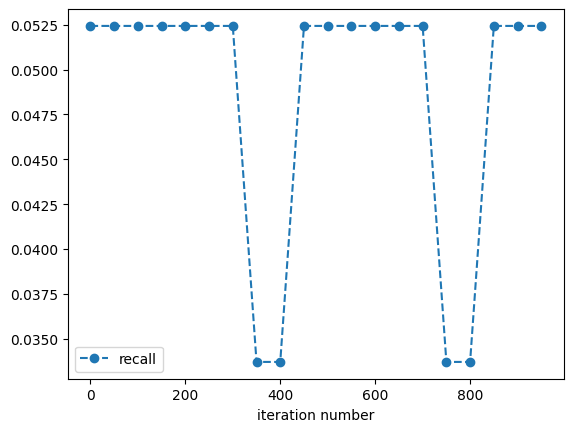

In [303]:
x = np.arange(0, 999, 50)
plt.figure()
#plt.plot(x, results.loc[x, 'information gain'], 'o--')
plt.plot(x, results.loc[x, 'recall'], 'o--', label= 'recall')
#plt.plot(x, results.loc[x, 'filter rate'], 'o--')
plt.xlabel('iteration number')
#plt.legend(['information', 'recall', 'filter rate'])
plt.legend()
#plt.savefig('newton_928.png')
plt.show()

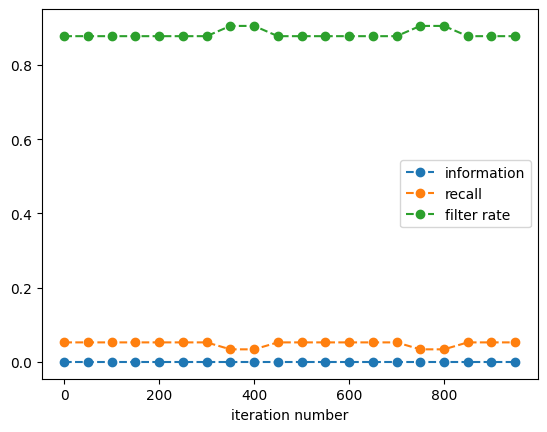

In [300]:
x = np.arange(0, 999, 50)
plt.figure()
plt.plot(x, results.loc[x, 'information gain'], 'o--')
plt.plot(x, results.loc[x, 'recall'], 'o--')
plt.plot(x, results.loc[x, 'filter rate'], 'o--')
plt.xlabel('iteration number')
plt.legend(['information', 'recall', 'filter rate'])
plt.savefig('newton_928.png')
plt.show()